## Importing Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualisierung
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Data Analysis
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Warning
import warnings
warnings.filterwarnings("ignore")

## Loading Dataset

In [2]:
# Load the dataset
data_raw = pd.read_csv('Assignment-1_Data.csv\Assignment-1_Data.csv', sep=';')
data_raw.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,01.12.2010 08:26,"2,55",17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,01.12.2010 08:26,"3,39",17850.0,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,01.12.2010 08:26,"2,75",17850.0,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,01.12.2010 08:26,"3,39",17850.0,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,01.12.2010 08:26,"3,39",17850.0,United Kingdom


In [3]:
# Get a summary of the dataset
print(data_raw.shape)
print(data_raw.info())

(522064, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522064 entries, 0 to 522063
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   BillNo      522064 non-null  object 
 1   Itemname    520609 non-null  object 
 2   Quantity    522064 non-null  int64  
 3   Date        522064 non-null  object 
 4   Price       522064 non-null  object 
 5   CustomerID  388023 non-null  float64
 6   Country     522064 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 27.9+ MB
None


## Data preparation
Before diving into the analysis, it's essential to ensure that our dataset is in the right format and free of inconsistencies. In this chapter, we'll walk through the steps taken to prepare our data for analysis. This includes converting date columns, cleaning up numeric formats, checking for missing values, and generating descriptive statistics.

In [4]:
# Converting Date Column
data_raw['Date'] = pd.to_datetime(data_raw['Date'], format='%d.%m.%Y %H:%M')
data_raw['YearMonth'] = data_raw['Date'].dt.to_period('M')

In [5]:
# We notice that 'Price' column has commas in the numeric values, let's replace them and convert it to float
data_raw['Price'] = data_raw['Price'].str.replace(',', '.').astype(float)

In [6]:
# We check for missing values in the dataset across all columns.
missing_values = data_raw.isnull().sum()
print(missing_values)

BillNo             0
Itemname        1455
Quantity           0
Date               0
Price              0
CustomerID    134041
Country            0
YearMonth          0
dtype: int64


This reveals missing values in columns 'Itemname' and 'CustomerID'.

In [7]:
# Descriptive Statistics 
data_raw.describe()

,Quantity,Price,CustomerID
count,522064.000000,522064.000000,388023.000000
mean,10.090435,3.826801,15316.931710
std,161.110525,41.900599,1721.846964
min,-9600.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13950.000000
50%,3.000000,2.080000,15265.000000
75%,10.000000,4.130000,16837.000000
max,80995.000000,13541.330000,18287.000000


## Data Filtering and Cleaning
A crucial aspect of data analysis is ensuring the data's integrity by filtering out irrelevant or erroneous entries and handling missing values appropriately. In this chapter, we focus on filtering out non-positive values, removing rows with missing item names, filling in missing customer IDs, and calculating total prices per transaction. These steps are vital to ensure the accuracy and reliability of our subsequent analysis.

In [8]:
# Filtering the dataset to include only rows with values > 0
data = data_raw[(data_raw['Quantity']>0) & (data_raw['Price']>0)]

In [9]:
# Dropping rows without item 
data = data[data['Itemname'].notnull()]

In [10]:
# Filling missing customer IDs
data = data.fillna('#NV')

In [11]:
# Calculate total price per pos / transaction
data['TotalPrice'] = data['Quantity'] * data['Price']

In [12]:
data.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country,YearMonth,TotalPrice
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12,15.30
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12,22.00
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34


## Explorative Data Analysis (EDA)
In this section, we delve into exploring our dataset to gain insights and identify patterns. We begin by examining the structure of our data using the .info() method, which provides a summary of the data types and non-null counts for each column.

In [13]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 519551 entries, 0 to 522063
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   BillNo      519551 non-null  object        
 1   Itemname    519551 non-null  object        
 2   Quantity    519551 non-null  int64         
 3   Date        519551 non-null  datetime64[ns]
 4   Price       519551 non-null  float64       
 5   CustomerID  519551 non-null  object        
 6   Country     519551 non-null  object        
 7   YearMonth   519551 non-null  period[M]     
 8   TotalPrice  519551 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(4), period[M](1)
memory usage: 39.6+ MB
None


**Total Sales Analysis**

We group the data by month and year, calculating the total sum of sales to understand the sales trend over time. The resulting visualization depicts the total sales per month.

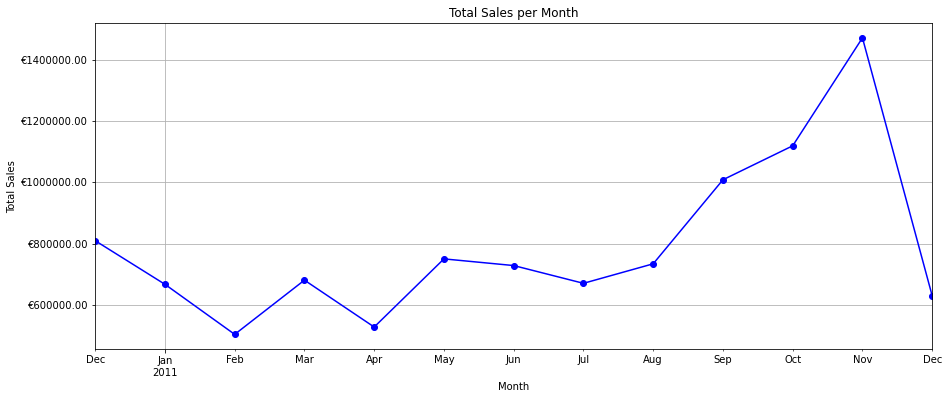

In [14]:
# Grouping the data by month and year, and calculating the total sum of sales
monthly_sales = data.groupby('YearMonth')['TotalPrice'].sum()

plt.figure(figsize=(15,6))
monthly_sales.plot(kind='line', marker='o', color='b')
plt.title('Total Sales per Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')

formatter = ticker.FormatStrFormatter('€%.2f')
plt.gca().yaxis.set_major_formatter(formatter)  

plt.grid(True)
plt.show()

**Unique Item Analysis**


Next, we analyze the uniqueness of items sold per month by grouping the data and calculating the count of unique items. The line plot visualizes the sum of unique items per month.

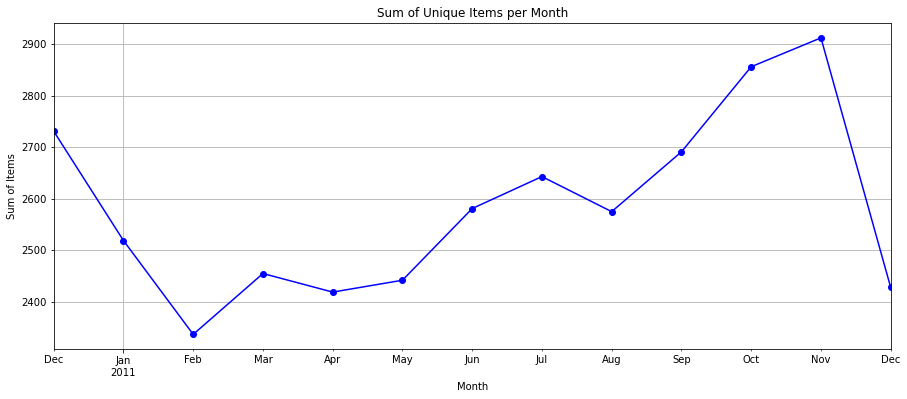

In [15]:
# Grouping the data by month and year, and calculating the unique items per month
monthly_item = data.groupby('YearMonth')['Itemname'].nunique()
plt.figure(figsize=(15,6))
monthly_item.plot(kind='line', marker='o', color='b')
plt.title('Sum of Unique Items per Month')
plt.xlabel('Month')
plt.ylabel('Sum of Items')
plt.grid(True)
plt.show()

## Market Basket Analysis
In this section, we embark on a crucial aspect of retail analytics: Market Basket Analysis. This technique allows us to uncover hidden patterns and associations among items purchased together, providing valuable insights for optimizing product placement, marketing strategies, and inventory management.

## MBA - Preprocessing


Before diving into analysis, we need to preprocess our transactional data. We select pertinent columns, such as 'BillNo' and 'Itemname', essential for identifying item associations. To facilitate analysis, we encode the items into a binary format using one-hot encoding, creating a basket representation where each row represents a transaction (BillNo) and each column represents an item. This step lays the groundwork for further analysis.

In [ ]:
# Preprocessing the data
data_processed = data[['BillNo', 'Itemname']]
data_encoded = pd.get_dummies(data_processed, columns=['Itemname'])
data_encoded.columns = data_encoded.columns.str.replace("Itemname_", "")
basket = data_encoded.groupby('BillNo').sum()

basket.head()

In [17]:
# Group by userID and aggregate bookTitles
grouped_df = data.groupby('BillNo')['Itemname'].apply(list).reset_index()
transactional_df = pd.DataFrame(grouped_df['Itemname'].tolist(), index=grouped_df['BillNo']).reset_index()
transactional_df.columns = ['BillNo'] + [f'Item{i+1}' for i in range(transactional_df.shape[1]-1)]
# transactional_df = transactional_df.fillna('')
transactional_df.tail()

,BillNo,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8,Item9,...,Item1105,Item1106,Item1107,Item1108,Item1109,Item1110,Item1111,Item1112,Item1113,Item1114
19556,572055,CHRISTMAS LIGHTS 10 VINTAGE BAUBLES,SET OF 6 T-LIGHTS CACTI,SET OF 6 T-LIGHTS SANTA,MOROCCAN BEATEN METAL DISH,RECYCLED ACAPULCO MAT RED,MIRROR MOSAIC CANDLE PLATE,RED HANGING HEART T-LIGHT HOLDER,RED RETROSPOT TISSUE BOX,BLUE DISCO HANDBAG,...,None,None,None,None,None,None,None,None,None,None
19557,572056,POSTAGE,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
19558,572057,TEA TIME OVEN GLOVE,FRYING PAN UNION FLAG,NOVELTY BISCUITS CAKE STAND 3 TIER,MINI CAKE STAND WITH HANGING CAKES,MINI CAKE STAND HANGING STRAWBERY,"FEATHER PEN,HOT PINK",None,None,None,...,None,None,None,None,None,None,None,None,None,None
19559,572058,DOOR HANGER MUM + DADS ROOM,BAKING MOULD CHOCOLATE CUPCAKES,SET/10 BLUE POLKADOT PARTY CANDLES,SET/3 ROSE CANDLE IN JEWELLED BOX,SET/3 OCEAN SCENT CANDLE JEWEL BOX,HAND WARMER BABUSHKA DESIGN,ENGLISH ROSE GARDEN SECATEURS,SET/10 PINK POLKADOT PARTY CANDLES,JUMBO BAG PINK POLKADOT,...,None,None,None,None,None,None,None,None,None,None
19560,A563185,Adjust bad debt,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


To simplify the analysis and focus solely on item presence, we convert the occurrence values to binary format. This binary transformation facilitates the identification of item associations, regardless of the quantity purchased in each transaction.

In [ ]:
# Binary transformation
basket[basket > 0] = 1

Generating Frequent Itemsets
Using the Apriori algorithm, we aim to extract frequent itemsets – combinations of items that frequently co-occur in transactions. These itemsets provide valuable insights into customer purchasing behaviors, revealing commonly associated products. 

In [ ]:
frequent_itemsets = apriori(basket, min_support=0.02, use_colnames=True)

- Konfidenz: Fokus auf die Wahrscheinlichkeit des Zusammenkaufs.
- Lift: Fokus auf die Abweichung vom Zufall.
- Support: Fokus auf die Häufigkeit des Auftretens.

## Association Rule Mining


In this phase, we employ association rule mining techniques to extract meaningful patterns and relationships between items in our dataset. By analyzing these rules, we can uncover actionable insights that drive business decisions, such as product placement strategies and targeted marketing campaigns.

**Confidence**

In [ ]:
# Confidence represents the likelihood that the consequent item (item bought after) is purchased given the antecedent item(s) (item bought before). 
# A confidence of 0.6 implies that the consequent item is purchased in 60% of transactions where the antecedent item(s) are also present, indicating a strong positive relationship.
rules_confidenz = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.8)
print(rules_confidenz.shape)
rules_c = rules_confidenz.round(3)
rules_c.head()

**Lift Analysis**

In [ ]:
# Lift measures how much more likely the consequent item(s) are purchased when the antecedent item(s) are present compared to when they are not. 
# A lift value of 1.0 indicates that the items in the consequent are bought together as often as would be expected by chance.
rules_lift = association_rules(frequent_itemsets, metric="lift", min_threshold= 2.5)
print(rules_lift.shape)
rules_l = rules_lift.round(3)
rules_l.head()

**Support Analysis**

In [ ]:
# Support quantifies the frequency with which a rule occurs in the dataset.
# A support of 0.05 means that the rule occurs in at least 5% of transactions, signifying its significance in the dataset.
rules_support = association_rules(frequent_itemsets, metric="support", min_threshold=0.03)
print(rules_support.shape)
rules_s = rules_support.round(3)
rules_s.head()

## Analysis of Association Rule Metrics

In this section, we visually inspect the distribution of key metrics associated with our association rules, namely Confidence, Lift, and Support. These histograms provide insights into the frequency and distribution of these metrics across the extracted association rules.

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# The histogram below illustrates the distribution of Confidence values among the association rules. 
sns.histplot(rules_c['confidence'], bins=20, ax=axes[0], kde=True)
axes[0].set_title('Distribution of Confidence')
axes[0].set_xlabel('Confidence')
axes[0].set_ylabel('Frequency')

# The histogram below illustrates the distribution of Lift values among the association rules. 
sns.histplot(rules_l['lift'], bins=20, ax=axes[1], kde=True)
axes[1].set_title('Distribution of Lift')
axes[1].set_xlabel('Lift')
axes[1].set_ylabel('Frequency')

# The histogram below illustrates the distribution of Support values among the association rules. 
sns.histplot(rules_s['support'], bins=20, ax=axes[2], kde=True)
axes[2].set_title('Distribution of Support')
axes[2].set_xlabel('Support')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()